# 멋진 단어사전 만들기
## 프로젝트: SentencePiece 사용하기

### 데이터 불러오기

In [1]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f65427dea30>)

In [3]:
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [4]:
print('데이터 개수 :', len(naver_df))

데이터 개수 : 200000


### 결측치, 중복 확인 및 제거

In [5]:
origin_len = len(naver_df)

In [6]:
naver_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [7]:
naver_df = naver_df.dropna(how='any')
print(naver_df.isnull().sum)


<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [8]:
print('결측치 제거 후 데이터 개수 :', len(naver_df))  

결측치 제거 후 데이터 개수 : 199992


In [9]:
cleaned_corpus = naver_df.drop_duplicates(['document'])   

In [10]:
print('중복 제거 후 데이터 개수 :', len(cleaned_corpus))

중복 제거 후 데이터 개수 : 194543


In [11]:
print('전처리 전 데이터 개수 :', origin_len)
print('전처리 후 데이터 개수 :', len(cleaned_corpus)) 
print('전처리 후 남은 데이터 양(%)', (len(cleaned_corpus)/origin_len)*100)

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543
전처리 후 남은 데이터 양(%) 97.2715


In [12]:
cleaned_corpus.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### 데이터 분석 및 전처리

In [13]:
naver_review = cleaned_corpus['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


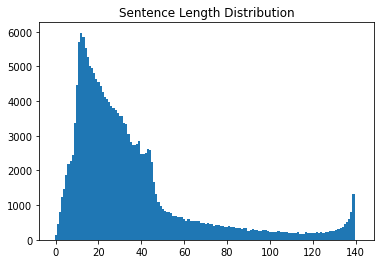

In [14]:
min_len = 999
max_len = 0
sum_len = 0

for sen in naver_review:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_review))

sentence_length = np.zeros((max_len), dtype=np.int_)

for sen in naver_review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [15]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return 

check_sentence_with_length(naver_review, 135)

내가 남자라그런가 이거 겁나 긴장감있고 흥미진진하던데..ㄷㄷ 나만그런가워낙에 격투씬을 좋아해서.ㅋㅋㅋ 그냥 아무생각없이 집에서 스마트티비로 봐서 재밌었나봄 이거 뭔영화인지도 모르고 암살에 나온 이정재 있길래 걍봄 ㅋㅋ 하여튼 너무 재밌게 봤음
줄리아 로버츠의 웃음은 정말 보는 사람을 기쁘게 해준다. 웃음 하나로 기쁨과 슬픔을 표현할 수 있는 배우..전통을 깨고 여성의 새로운 삶을 살으라고 영화는 보여주는 데 영화에서는 전통을 완전히 벗어나야 한다는 것만을 강조하는 것 같아 아쉽다.
평점 왜 이렇게 낮아요??? 영화 대박인데...진짜....ㅋㅋㅋ 와.. 어떻게 이런상상을 해서 이런 영화를... 대박대박.. ㅠ 생각지못한 반전.. 처음엔 반신반의하면서 봤는데.. 최고내요...ㄷㄷㄷ 근데 금발 여주는 중반에 좀 짜증나긴했음ㅋ
큰 기대 안하고 띄엄띄엄 보다가 집중해서 봤네요!! 저는 잘봤습니다. 액션도 뛰어나고 아슬아슬한 장면들을 극복해 가는게 나름 잼있었어요!! 마지막에 여자 박사가 살았는지 죽었는지가 안나와서 좀 아쉽네요..그래도 딸은 살렸으니 다행스럽다는 ㅎㅎ
누군가는 잃고, 누군가는 벌고, 또 누군가는 죽는 게임. 그리고 끊임없이 반복되는 삶과 기억의 굴레. 하지만 시작할 때부터 영화는 이미 심각했고, 지루했다. 다 본 후 생각해보니 그럴 수밖에 없었겠다 싶다. 넓고 얕은 재미, 길고 깊은 여운.
영화내용은 사실별거 없지만 보고나면 생각을 많이하게 되는 영화임. 재미있기도 하고, 결론은 무엇이냐 하면 빨갱이들이 아무것도 모르는 사람들 선동해서 비참한 결과를 낳게 한다는 내용임. 복수심에 불타는 이북출신들도 나오는데 다 역사적인 사실임.
고등학교때 보고 지금에서 생각난 영화 참~그땐 눈물 콧물 흘리면서 봤는데짐 보면 나올라나.. 하긴 세월이 많이 흘렀지 아마 짐 시대하곤 스토리자체가 뻔하니깐 하지만 지금도 잊혀지지않는장면은 주인공이 공부하는장면과하늘도 갈라놓지 못한 그들의사랑
오스카는 흔히 볼수있는 아들이자 장난끼 많은 오빠 그리고 항상 미안해하는 남편. 감정이

In [16]:
# sentence_length[문장 길이] = 갯수 
# idx = 문장길이 , _sum = 해당 문장 길이인 문장의 개수 

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 135 초과하는 문장 길이를 추출합니다.
    if _sum > 135:
        print("Outlier Index:", idx+1)

Outlier Index: 2
Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56
Outlier Index: 57


### 문장 길이 확인

In [17]:
check_sentence_with_length(naver_review, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


In [18]:
check_sentence_with_length(naver_review, 10)

내용이너무좋아요.ㅎ
뀰잼이다뀰잼이라구여
13살이엇냐?...
알파치노 연기때문에
이물감. 시 같았다
매력적인 영화...
이거 재밌는데...
.겁쟁이페달보고싶다
한국 영화치고 좋다
정말 멋진 결말!ㅎ
너무 잘 봣어요..
도라에몽 최고~!!
정말 재밋내요..굿
너무끔찍하네요ㅜㅜㅜ
유지태 너무 멌있다
진짜..쩔지..ㅜㅜ
개꿀재밋다뿌잉최고임
박보영 나와서 추천
그냥 재밌습니다^^
카이키는차캤습니다.
이거왜청불임????
소재가 새로웠던..
이거완전 추전!~~
1236547890
평점이왜이래....
조용하고 잔잔한영화
왜안 저스티스리그요
영화의매력에빠졌어요
피터팬너무좋아요ㅠㅠ
엄청재밌어요정의성굳
계속 울었다..ㅜㅜ
재밋다 그외는 없고
재미나요~귀여워요~
내가본한국최고의애니
인간은 자유의 노예
만세!!!!짱재밌음
아날로그적 감성..
완전 재밌다 ㅋㅋㅋ
유덕화아저씨잘생겼다
통일호 화장실 강추
구르재매맴잼잼잼잼젬
아직까지도 여운이.
스크림보다 재밌네!
좋았다.(열자..)
지극히 붉은 영화.
이거죠~이거!!!!
여운이너무많이남아요
스티브잡스가생각나요
제시카 알바 좋아요
정말 잘 만든 사극
나쁘지많은않은...
재밌네 이거 ㅋㅋㅋ
난 너무 재밌엇음~
보.고.싶.다.!!
즐겁게 볼수있었던!
Very good!
여자 걸그룹이 이쁨
7.32 라니 ㅋㅋ
전편 다보고싶다..
좋다~~ 사랑스러운
진짜감동이다감동이야
나는 재미있게 봤다
애니의새로운 개척점
감동이 있는 이야기
재미있게 봤어요^^
가나다라마바사아자차
좋아요정말좋아요정말
엄청재밌어요꼭보세요
정말 잘 만들어졌음
넝쿨째굴러온당신짱!
야하지만 좀 재밌다
정말대단한거같다는ㅋ
굿굿굿굿굯굿굿굿귯귯
이것도 꽤 명작이지
최고의 영화중 한편
잔잔한 멋이 있네요
겁나재밌었음!!!!
내인생최고의액션영화
감동의 물결....
볼만함~재밋음~굿굿
정말재밌게잘봤습니다
장근석존잘박신혜존예
솔직히 재밌다 ㅋㅋ
늘 감동이었네요..
배울점이많은영화ㅋㅋ
일주일만에 다봣다.
재미있게 본 영화~
멋지고 감동적이다.
너무 좋은 영화예요
이영아 넘 이뻐^^
붉은매다시보고싶다.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


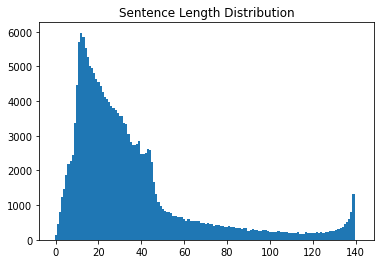

In [19]:
min_len = 999
max_len = 0
sum_len = 0

# cleaned_corpus = list(set(naver_review))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(naver_review)) 

for sen in naver_review:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int_)

for sen in naver_review:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 최적의 max_len을 찾는 함수

In [20]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:
below_threshold_len(36, naver_review)  # 평균
below_threshold_len(140, naver_review)  # 최장 
below_threshold_len(70, naver_review)  # 중앙값
below_threshold_len(50, naver_review)  
below_threshold_len(60, naver_review)  

전체 샘플 중 길이가 36 이하인 샘플의 비율: 66.08616090016089
전체 샘플 중 길이가 140 이하인 샘플의 비율: 99.99948597482305
전체 샘플 중 길이가 70 이하인 샘플의 비율: 88.66523082300571
전체 샘플 중 길이가 50 이하인 샘플의 비율: 82.05640912291884
전체 샘플 중 길이가 60 이하인 샘플의 비율: 85.86739178484962


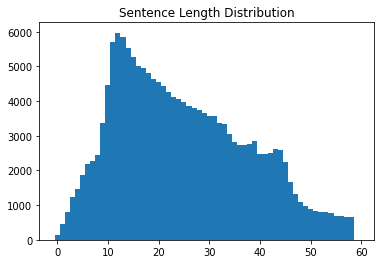

In [22]:
max_len = 60   
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len)]

train_data = cleaned_corpus[cleaned_corpus['document'].str.len() < max_len]   



# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int_)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [23]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495, 2625,
       2599, 2257, 1660, 1311, 1079,  968,  893,  844,  799,  789,  765,
        678,  686,  654,  658,    0])

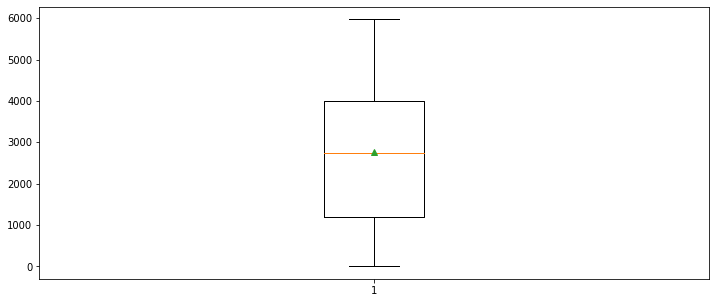

In [24]:
plt.figure(figsize=(12,5))
plt.boxplot([sentence_length], showmeans=True)
plt.show()

In [25]:
print('전처리 전 데이터 개수 :', len(naver_df))
print('전처리 후 데이터 개수 :', len(train_data))
print('전처리 후 남은 데이터 양(%)', (len(train_data)/len(naver_df))*100)

전처리 전 데이터 개수 : 199992
전처리 후 데이터 개수 : 166401
전처리 후 남은 데이터 양(%) 83.20382815312612


### SentencePiece 모델 학습

In [26]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

# vocab size=8000, model_type=unigram
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_8k --vocab_size={}'.format(temp_file, vocab_size)    
)

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l kor_spm_unigram_8k*



sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=kor_spm_unigram_8k --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: kor_spm_unigram_8k
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_v

-rw-r--r-- 1 root root 375096 Mar 23 08:02 kor_spm_unigram_8k.model
-rw-r--r-- 1 root root 144435 Mar 23 08:02 kor_spm_unigram_8k.vocab


In [27]:
# vocab size=8000, model_type=bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l kor_spm_bpe_8k*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: kor_spm_bpe_8k
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_

-rw-r--r-- 1 root root 370378 Mar 23 08:02 kor_spm_bpe_8k.model
-rw-r--r-- 1 root root 115580 Mar 23 08:02 kor_spm_bpe_8k.vocab


In [28]:
vocab_list = pd.read_csv('kor_spm_unigram_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.27463
4,.,-3.47852
5,..,-4.24637
6,▁영화,-4.42651
7,이,-4.44480
8,...,-4.48456
9,가,-4.71341


In [29]:
print('subword의 개수 :', len(vocab_list))
vocab_list.sample(10)

subword의 개수 : 8000


,0,1
4055,랄까,-10.11200
6100,템,-10.67380
2654,죄,-9.66382
2820,▁동물,-9.73024
4071,<,-10.12030
7427,넷,-11.22030
3367,▁충격적,-9.91503
5898,하는구나,-10.60720
2460,▁잔잔하고,-9.58352
2823,머리,-9.73203


### SentencePiece 성능 비교평가

In [30]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [31]:
print('kor_spm_unigram_8k')
test_performance(model='kor_spm_unigram_8k.model')

print('kor_spm_bpe_8k')
test_performance(model='kor_spm_bpe_8k.model')

kor_spm_unigram_8k
[1653, 9, 464, 16, 1383, 9, 158, 15, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_8k
[6043, 990, 6533, 6257, 1506, 6252, 6360, 6246, 6244]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### Tokenizer 함수 작성

In [32]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [33]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()

s.Load('kor_spm_unigram_8k.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'kor_spm_unigram_8k')           
print(tensor)

print('kor_spm_bpe_8k')
test_performance(model='kor_spm_bpe_8k.model')

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  517 3252
    14 1097 2572    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1592 2168  228  544    9
   280 7921  756    8]]
kor_spm_bpe_8k
[6043, 990, 6533, 6257, 1506, 6252, 6360, 6246, 6244]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### lstm으로 감정분석 모델 학습

In [34]:
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], 'kor_spm_unigram_8k')

In [35]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [36]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

106496 26624 33281
106496 26624 33281


In [37]:
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                    ))
            
model_LSTM.add(keras.layers.LSTM(128))
# model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [38]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [39]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)

Epoch 1/20
1664/1664 [==============================] - 208s 123ms/step - loss: 0.4057 - accuracy: 0.8140 - val_loss: 0.3520 - val_accuracy: 0.8438
Epoch 2/20
1664/1664 [==============================] - 205s 123ms/step - loss: 0.3153 - accuracy: 0.8626 - val_loss: 0.3350 - val_accuracy: 0.8515
Epoch 3/20
1664/1664 [==============================] - 206s 124ms/step - loss: 0.2774 - accuracy: 0.8796 - val_loss: 0.3378 - val_accuracy: 0.8527
Epoch 4/20
1664/1664 [==============================] - 206s 124ms/step - loss: 0.2476 - accuracy: 0.8936 - val_loss: 0.3544 - val_accuracy: 0.8478
Epoch 5/20
1664/1664 [==============================] - 206s 124ms/step - loss: 0.2222 - accuracy: 0.9047 - val_loss: 0.3647 - val_accuracy: 0.8465
Epoch 6/20
1664/1664 [==============================] - 205s 123ms/step - loss: 0.1957 - accuracy: 0.9187 - val_loss: 0.4126 - val_accuracy: 0.8407
Epoch 00006: early stopping


In [40]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
print(results)

832/832 - 23s - loss: 0.4136 - accuracy: 0.8412
[0.4135960340499878, 0.8411583304405212]


### 모델 성능 비교 평가

In [41]:
def performance_test_spm(spm_model, vocab_size, word_vector_dim):
    s = spm.SentencePieceProcessor()
    s.Load("{}.model".format(spm_model)) 
    
    tensor, word_index, index_word = sp_tokenize(s, train_data['document'], spm_model)
    
    x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    

    model_LSTM = keras.Sequential()
    model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                     word_vector_dim,
                                        ))

    model_LSTM.add(keras.layers.LSTM(128))
    model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model_LSTM.summary()
    
    model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
    epochs=10
    batch_size=64
    
    
    history_LSTM = model_LSTM.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val,y_val),
                        callbacks=[es],
                        verbose=1)
    
    results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
    print(results)
    
    return history_LSTM

In [42]:
history_unigram_8k_dim_8 = performance_test_spm('kor_spm_unigram_8k', vocab_size, word_vector_dim=8)
history_unigram_8k_dim_64 = performance_test_spm('kor_spm_unigram_8k', vocab_size, word_vector_dim=64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 190s 113ms/step - loss: 0.4141 - accuracy: 0.8079 - val_loss: 0.3625 - val_accuracy: 0.8398
Epoch 2/10
1664/1664 [==============================] - 190s 114ms/step - loss: 0.3335 - accuracy: 0.8560 - val_loss: 0.3521 - val_accuracy: 0.8449
Epoch 3/10
1664/1664 [==============================] - 189s 114ms/step - loss: 0.

### 학습 과정 평가

In [43]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

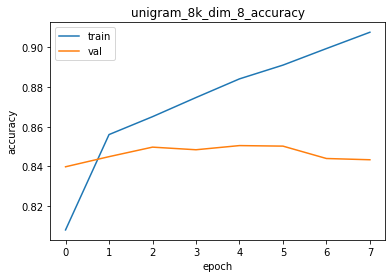

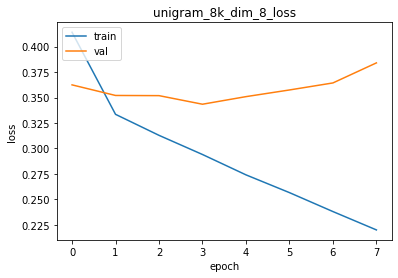

In [44]:
visualize_train(history_unigram_8k_dim_8, param='unigram_8k_dim_8')

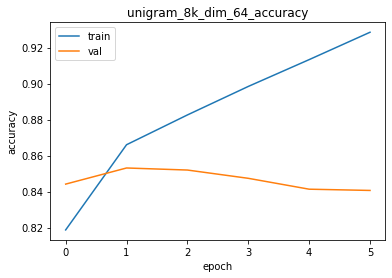

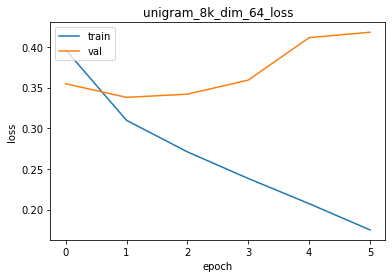

In [45]:
visualize_train(history_unigram_8k_dim_64, param='unigram_8k_dim_64')

# 회고

네이버 영화분석을 하는거라 ex6번을 참고해서 하였으나 잘 안되서 다른것 찾아서 참고함. 혼자 만드는것에 대하여 많은 어려움을 느낀다. 그래서 구글링을 하여 많이 참고할수밖에 없었다. 이해하려고 많이 보고 시도해봤지만 아직 파악하는데 어려움을 겪고있다. 시도 해도 잘 안되는 부분이 많았고 더이상 진행되지 않고 멈추는 곳이 많이 있어서 더욱 다양한 시도를 해볼수 없었다. 많이 보고 많이 따라하면서 더욱더 개념을 다질 필요성을 느낀다.